In [33]:
import fbprophet 
import pandas as pd
from math import sqrt
import numpy as np
import warnings
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
# don't do this at home
warnings.filterwarnings("ignore")
# high resolution 
%config InlineBackend.figure_format = 'retina'

In [2]:
# def validate():
"""
>> takes in 
    > Census 1970-2010 dataframe (1 df)
        >> total population by Place measurements
    > American Community Survey (ACS) 2011-2017 dataframes (7 dfs)
        >> total population (age & sex) by Place 

>> forges DataFrame of places that have 
    > at least one (1) recording for Census years 1970-2010
    > at least one (1) recording for ACS years 2011-2015

>> test our model v. base on
    > random sample 100 Places
    > random sample 100 Places from bottom half population size
    > random sample 100 Places from top half population size
"""

'''load Train data'''
# population by Place Census 1970-2010 measurements
load_census_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''load Test data'''
# population by Place ACS 2016
load_acs_20l6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2017
load_acs_20l7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''find common places across Census and each train ACS'''
# identify Places measured in 2011 ACS [0 == 'Geography']
acs11places = [place for place in load_acs_20l1['GEO.display-label'][1:]]
# identify Places measured in 2012 ACS 
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS 
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS 
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

# cross 2011-2015, keep coexisting Places
train_places = [place for place in acs11places if place in acs12places and acs13places and acs14places and acs15places]


'''find common places across 2016 & 2017 (test ACSs)'''
# identify Places measured in 2016 ACS (29575) [0 == 'Geography']
acs16places = [place for place in load_acs_20l6['GEO.display-label'][1:]]
# identify Places measured in 2017 ACS (29577)
acs17places = [place for place in load_acs_20l7['GEO.display-label']]

# cross 2017 Places w/ 2016 Places, keep coexisting Places (29551)
base_places = [place for place in acs17places if place in acs16places]


'''find common Places across the Places our model will train on {train_places} 
    and the Places our model can predict on {base_places}'''
# identify Places we can compare our predictions with
measureable_places = [place for place in train_places if place in base_places]


'''clean Census 1970-2010 df (Train)'''
# identify columns needed to make GEO.display-label column (so can pair with ACS DataFrames) 
for_geo_displays = ['PLACE','STATE']
# pull those columns 
to_geo_displays = load_census_place[for_geo_displays]

# mold PLACE column into list with Place formatted as is in GEO.display-label
places_70_10 = [place + ', ' for place in to_geo_displays.PLACE]

# list paired State for each Place
states_70_10 = [state for state in to_geo_displays.STATE]

# merge places_70_10 and states_70_10 into list formatted as GEO.display-label column
GEO_display_label = [ places_70_10[i] + states_70_10[i] for i in range(len(places_70_10))]

# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']
# set base dataframe using Census (1970-2010) measurements 
pop_place_70_10_ = load_census_place[place_cols_of_interest]

# add GEO.display-label column from GEO_display_label list
pop_place_70_10_['GEO.display-label'] = GEO_display_label


'''clean American Community Survey (ACS) 2011-2015 dataframes (Train)'''
# ID columns we will be using
columns = ['GEO.display-label', 'HC01_EST_VC01']
# convert 2011
acs_20l1 = load_acs_20l1[columns]
# convert 2012
acs_20l2 = load_acs_20l2[columns]
# convert 2013
acs_20l3 = load_acs_20l3[columns]
# convert 2014
acs_20l4 = load_acs_20l4[columns]
# convert 2015
acs_20l5 = load_acs_20l5[columns]


'''convert Train years to reflect Places only seen in measureable_places'''
# drop Census Places not ideal for measurement (29346)
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2011_place_populations = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2012_place_populations = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2013_place_populations = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2014_place_populations = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2015_place_populations = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(measureable_places)]


'''clean ACS 2016 & 2017 dataframes (Test)
    take a sample of 100 Places to score our model'''
# identify 2016/2017 columns of interest (to measure against)
test_col_of_i = ['GEO.display-label', 'HC01_EST_VC01']

# shrink ACS 2017 df to columns to measure against only 
testd_16_ = load_acs_20l6[test_col_of_i]
# realize ACS 2016 combined measureable_places DataFrame (Baseline) dataframe 
test_16_df_ = testd_16_.loc[testd_16_['GEO.display-label'].isin(measureable_places)]

# shrink ACS 2017 df to columns to measure against only 
testd_17_ = load_acs_20l7[test_col_of_i]
# realize ACS 2017 combined measureable_places DataFrame (Baseline) dataframe 
test_17_df_ = testd_17_.loc[testd_17_['GEO.display-label'].isin(measureable_places)]
# change 2017 populations from strings to ints
test_17_ints = [int(i) for i in test_17_df_.HC01_EST_VC01]
test_17_df_.HC01_EST_VC01 = test_17_ints
# forget Places with Total Population less than 1000 value in 2017 (will be sampling from 2017, values of 0 in 2016 are also 0 in 2017 or do not exits)
test_17_df_ = test_17_df_.loc[test_17_df_.HC01_EST_VC01 > 999]

In [4]:
'''
identify place of interest
'''

# locate and pull cities of interest
city_sfo = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'San Francisco city, California']
city_nyc = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New York city, New York']
city_nola = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New Orleans city, Louisiana']
city_houston = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Houston city, Texas']
city_bville = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Bentonville city, Arkansas']
city_sidney = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Sidney city, Nebraska']
city_pleasanton = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Pleasanton city, California']
sample_one_hunnit = pd.concat([city_sfo,city_nyc,city_nola,city_houston,city_bville,city_sidney,city_pleasanton])
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]
sample_places

['San Francisco city, California',
 'New York city, New York',
 'New Orleans city, Louisiana',
 'Houston city, Texas',
 'Bentonville city, Arkansas',
 'Sidney city, Nebraska',
 'Pleasanton city, California']

In [5]:
'''adjust Train dataframes to sampled Places'''
# shrink Census DataFrame to sampled Places
_s_census_ = census_place_populations.loc[census_place_populations['GEO.display-label'].isin(sample_places)]
# shrink 2011 ACS df to sampled Places 
_s_acs_2011_ = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(sample_places)]
# shrink 2012 ACS DataFrame to sampled Places 
_s_acs_2012_ = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(sample_places)]
# shrink 2013 ACS df to Places in sample  
_s_acs_2013_ = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(sample_places)]
# shrink 2014 ACS DataFrame to sampled Places 
_s_acs_2014_ = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(sample_places)]
# shrink 2015 ACS df to sampled Places 
_s_acs_2015_ = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(sample_places)]


'''adjust Test dataframes to sampled Places'''
# 2016 ACS df to sampled Places 
test_16_df = test_16_df_.loc[test_16_df_['GEO.display-label'].isin(sample_places)]
# 2017 ACS DataFrame to sampled Places 
test_17_df = test_17_df_.loc[test_17_df_['GEO.display-label'].isin(sample_places)]


'''forge Train DataFrame'''
# set Census index to Places, and forget Place column 
s_census_ = _s_census_.copy().set_index(_s_census_['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# rename Census columns to years for later datetime conversion
s_census_.columns = ['1970','1980','1990','2000','2010']

# set 2011 index to Places 
s_acs_2011_ = _s_acs_2011_.copy().set_index(_s_acs_2011_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2011_.columns = ['no','2011']
s_acs_2011_ = s_acs_2011_['2011']

# set 2012 index to Places 
s_acs_2012_ = _s_acs_2012_.copy().set_index(_s_acs_2012_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2012_.columns = ['no','2012']
s_acs_2012_ = s_acs_2012_['2012']

# set 2013 index to Places 
s_acs_2013_ = _s_acs_2013_.copy().set_index(_s_acs_2013_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2013_.columns = ['no','2013']
s_acs_2013_ = s_acs_2013_['2013']

# set 2014 index to Places 
s_acs_2014_ = _s_acs_2014_.copy().set_index(_s_acs_2014_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2014_.columns = ['no','2014']
s_acs_2014_ = s_acs_2014_['2014']

# set 2015 index to Places 
s_acs_2015_ = _s_acs_2015_.copy().set_index(_s_acs_2015_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2015_.columns = ['no','2015']
s_acs_2015_ = s_acs_2015_['2015']

# forge Train DataFrame and convert NaN values to 0 (assumes population not measured is 0) 
train_df = pd.concat([s_census_,s_acs_2011_,s_acs_2012_,s_acs_2013_,s_acs_2014_,s_acs_2015_],axis=1).fillna(0)

In [14]:
train_df

,1970,1980,1990,2000,2010,2011,2012,2013,2014,2015
GEO.display-label,,,,,,,,,,
"Bentonville city, Arkansas",5508.0,8756.0,11257.0,19730.0,35301.0,34022,35635,37131,38572,40368
"Pleasanton city, California",18328.0,35160.0,50553.0,63654.0,70285.0,69220,70329,71488,73164,75009
"San Francisco city, California",715674.0,678974.0,723959.0,776733.0,805235.0,797983,807755,817501,829072,840763
"New Orleans city, Louisiana",593471.0,557515.0,496938.0,484674.0,343829.0,321409,341407,357013,368471,376738
"Sidney city, Nebraska",6403.0,6010.0,5959.0,6282.0,6757.0,6772,6768,6770,6801,6830
"New York city, New York",7894862.0,7071639.0,7322564.0,8008278.0,8175133.0,8128980,8199221,8268999,8354889,8426743
"Houston city, Texas",1232802.0,1595138.0,1630553.0,1953631.0,2099451.0,2089090,2107449,2134707,2167988,2217706


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse          rmse           mae      mape  coverage
0  159 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
1  164 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
2  169 days  1.944603e+07   4409.765821   4409.765821  0.123748       0.0
3  175 days  6.370244e+05    798.138078    798.138078  0.021495       1.0
4  180 days  3.974565e+06   1993.631026   1993.631026  0.051686       1.0
5  339 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
6  344 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
7  349 days  1.944603e+07   4409.765821   4409.765821  0.123748       1.0
8  355 days  6.370244e+05    798.138078    798.138078  0.021495       1.0
9  360 days  3.974565e+06   1993.631026   1993.631026  0.051686       1.0
10 365 days  1.305370e+07   3612.991115   3612.991115  0.089501       1.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse         rmse          mae      mape  coverage
0  159 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
1  164 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
2  169 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
3  175 days  1.947412e+07  4412.949225  4412.949225  0.061730       0.0
4  180 days  2.368514e+06  1538.997725  1538.997725  0.021035       0.0
5  339 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
6  344 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
7  349 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
8  355 days  1.947412e+07  4412.949225  4412.949225  0.061730       0.0
9  360 days  2.368514e+06  1538.997725  1538.997725  0.021035       0.0
10 365 days  1.072989e+06  1035.851591  1035.851591  0.013810       1.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse          rmse           mae      mape  coverage
0  159 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
1  164 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
2  169 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
3  175 days  8.738977e+07   9348.249695   9348.249695  0.011435       0.0
4  180 days  9.336506e+07   9662.559620   9662.559620  0.011655       1.0
5  339 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
6  344 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
7  349 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
8  355 days  8.738977e+07   9348.249695   9348.249695  0.011435       0.0
9  360 days  9.336506e+07   9662.559620   9662.559620  0.011655       1.0
10 365 days  2.934432e+08  17130.184912  17130.184912  0.020375       0.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse          rmse           mae      mape  coverage
0  159 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
1  164 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
2  169 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
3  175 days  2.412760e+06   1553.306127   1553.306127  0.004351       0.0
4  180 days  2.375732e+09  48741.483295  48741.483295  0.132280       0.0
5  339 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
6  344 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
7  349 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
8  355 days  2.412760e+06   1553.306127   1553.306127  0.004351       0.0
9  360 days  2.375732e+09  48741.483295  48741.483295  0.132280       0.0
10 365 days  1.660708e+09  40751.779400  40751.779400  0.108170       0.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse        rmse         mae      mape  coverage
0  159 days   1054.482687   32.472799   32.472799  0.004806       1.0
1  164 days     82.539216    9.085110    9.085110  0.001342       0.0
2  169 days    427.848866   20.684508   20.684508  0.003056       0.0
3  175 days    235.533108   15.347088   15.347088  0.002267       1.0
4  180 days  13334.520829  115.475196  115.475196  0.016979       0.0
5  339 days   1054.482687   32.472799   32.472799  0.004806       1.0
6  344 days     82.539216    9.085110    9.085110  0.001342       0.0
7  349 days    427.848866   20.684508   20.684508  0.003056       0.0
8  355 days    235.533108   15.347088   15.347088  0.002267       1.0
9  360 days  13334.520829  115.475196  115.475196  0.016979       0.0
10 365 days   3048.366175   55.212011   55.212011  0.008084       0.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse           rmse            mae      mape  coverage
0  159 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
1  164 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
2  169 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
3  175 days  1.003314e+11  316751.346040  316751.346040  0.038306       0.0
4  180 days  5.250506e+07    7246.037206    7246.037206  0.000867       1.0
5  339 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
6  344 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
7  349 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
8  355 days  1.003314e+11  316751.346040  316751.346040  0.038306       0.0
9  360 days  5.250506e+07    7246.037206    7246.037206  0.000867       1.0
10 365 days  5.906435e+09   76853.332535   76853.332535  0.009120       1.0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2009-01-27 00:00:00 and 2014-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


    horizon           mse           rmse            mae      mape  coverage
0  159 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
1  164 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
2  169 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
3  175 days  4.852790e+09   69661.969447   69661.969447  0.032633       0.0
4  180 days  1.224800e+09   34997.137848   34997.137848  0.016143       1.0
5  339 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
6  344 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
7  349 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
8  355 days  4.852790e+09   69661.969447   69661.969447  0.032633       0.0
9  360 days  1.224800e+09   34997.137848   34997.137848  0.016143       1.0
10 365 days  1.057774e+09   32523.445195   32523.445195  0.014665       1.0


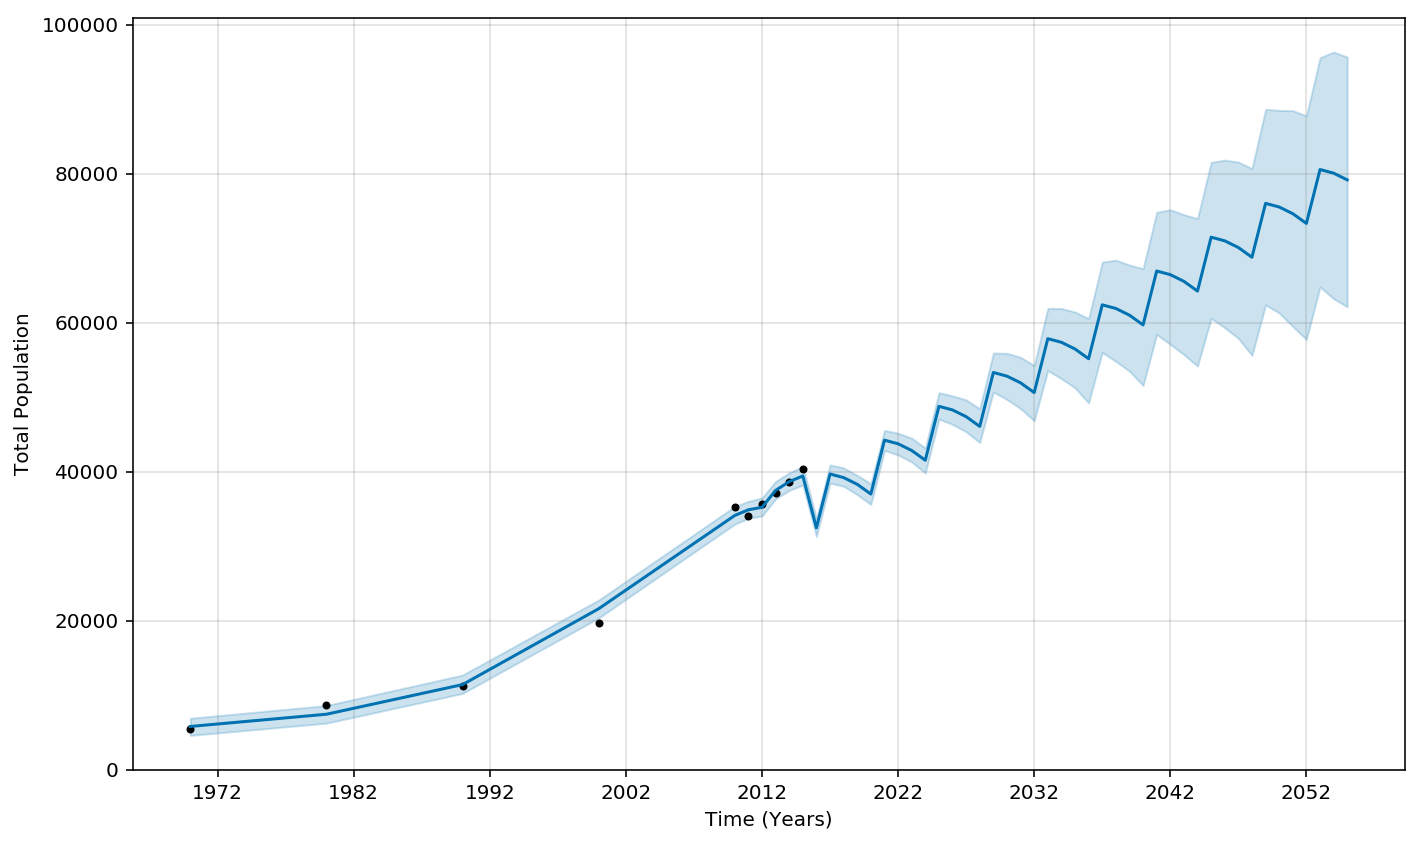

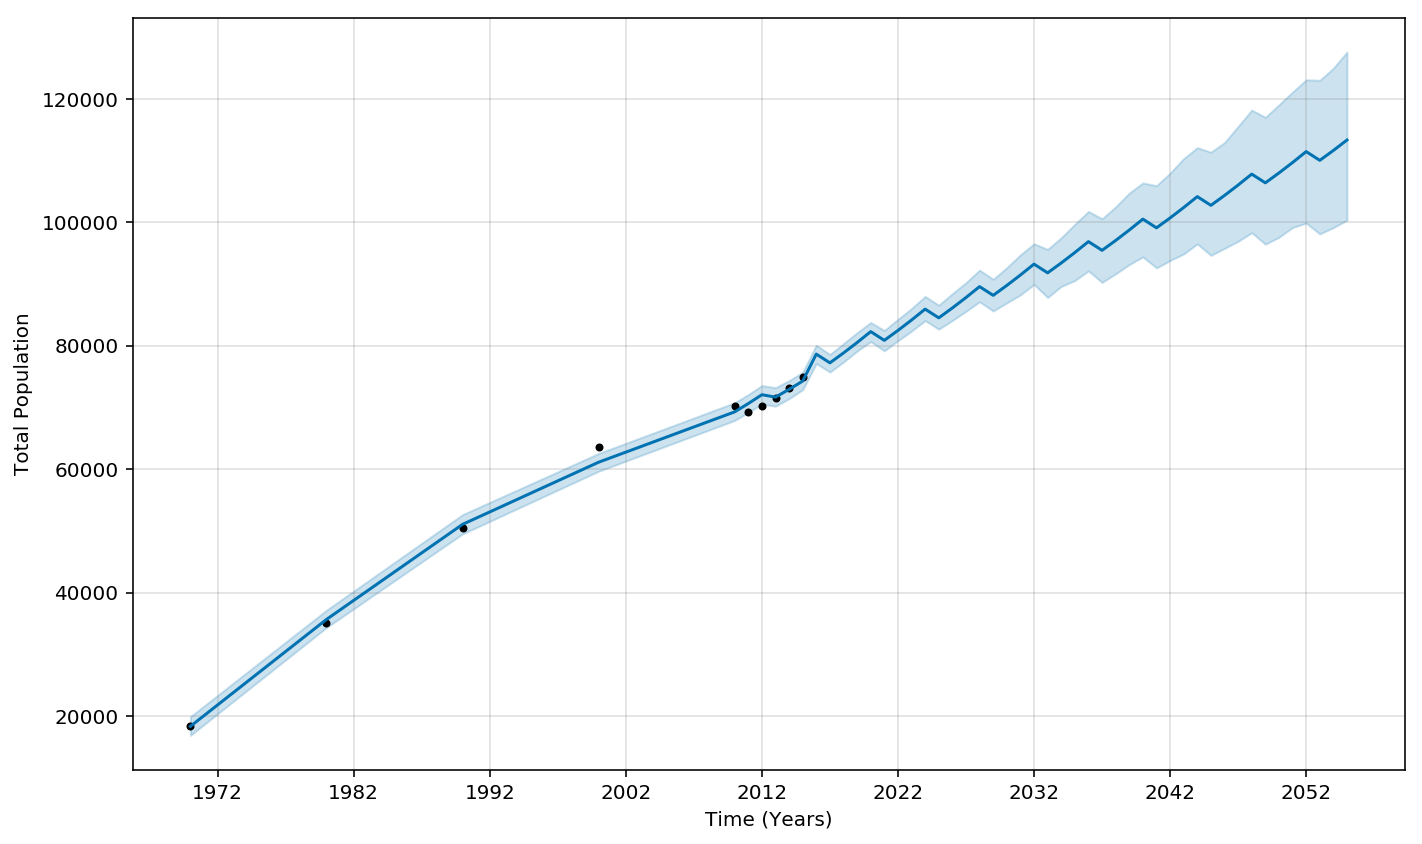

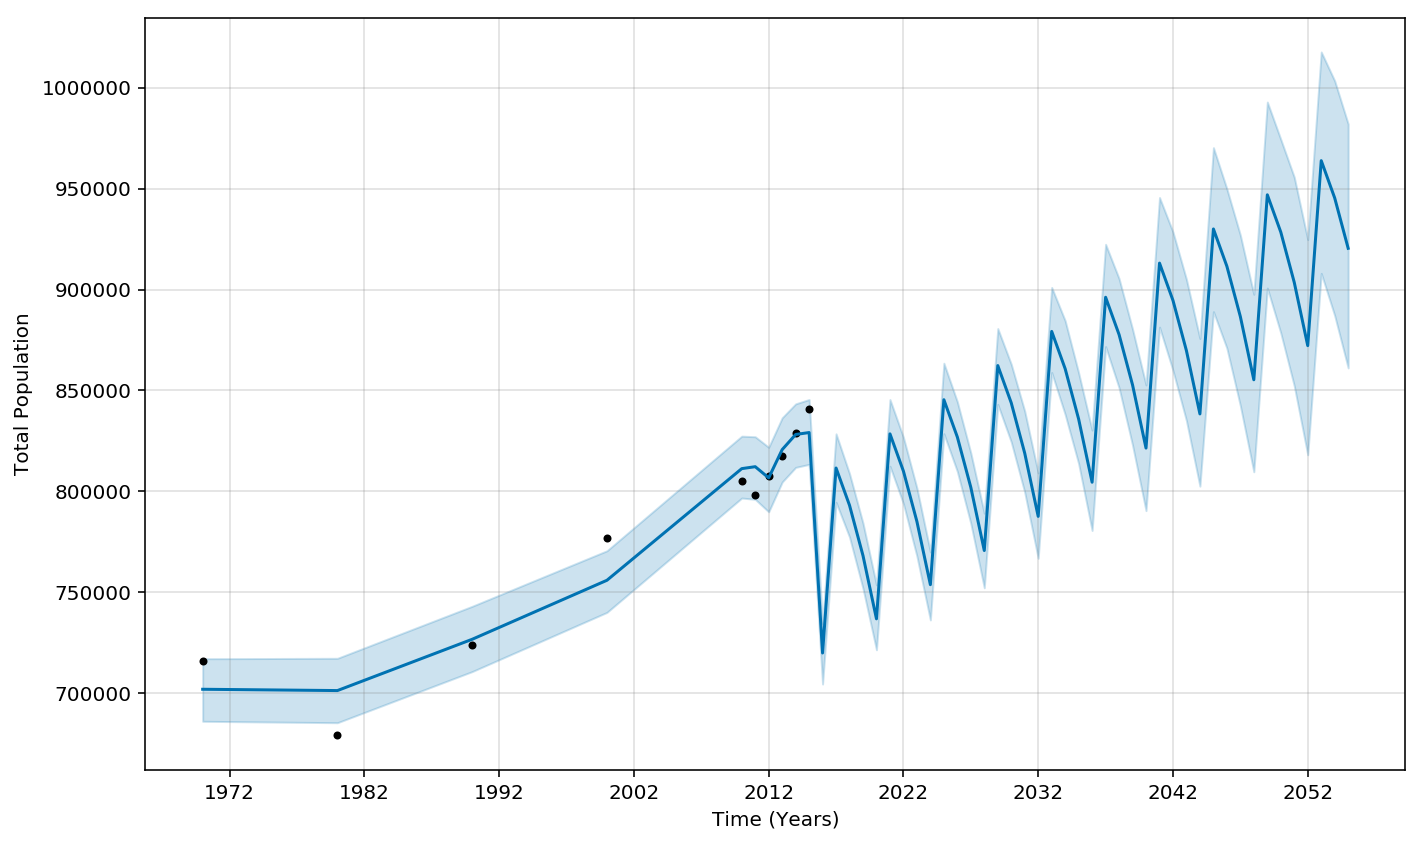

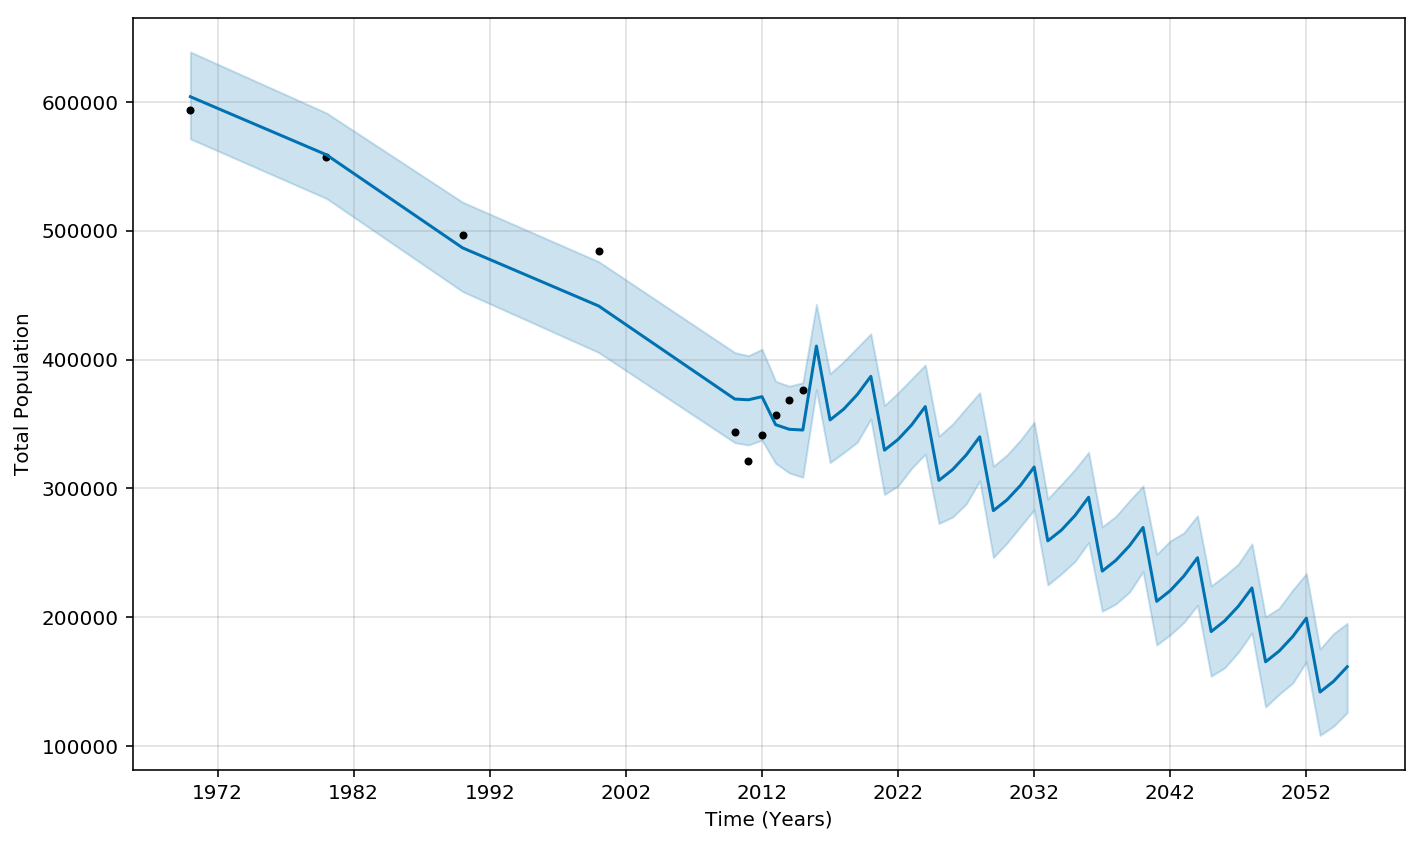

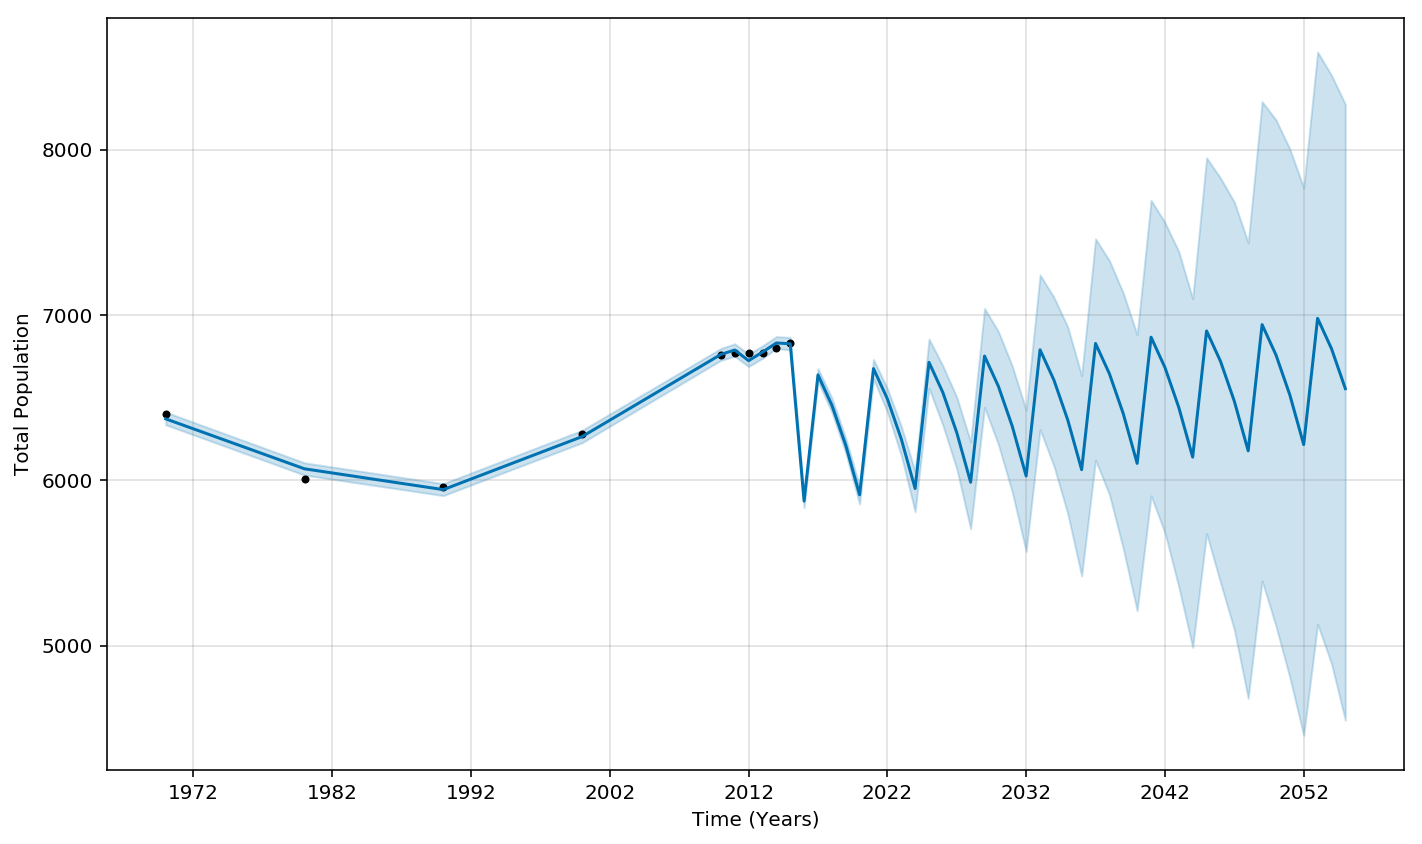

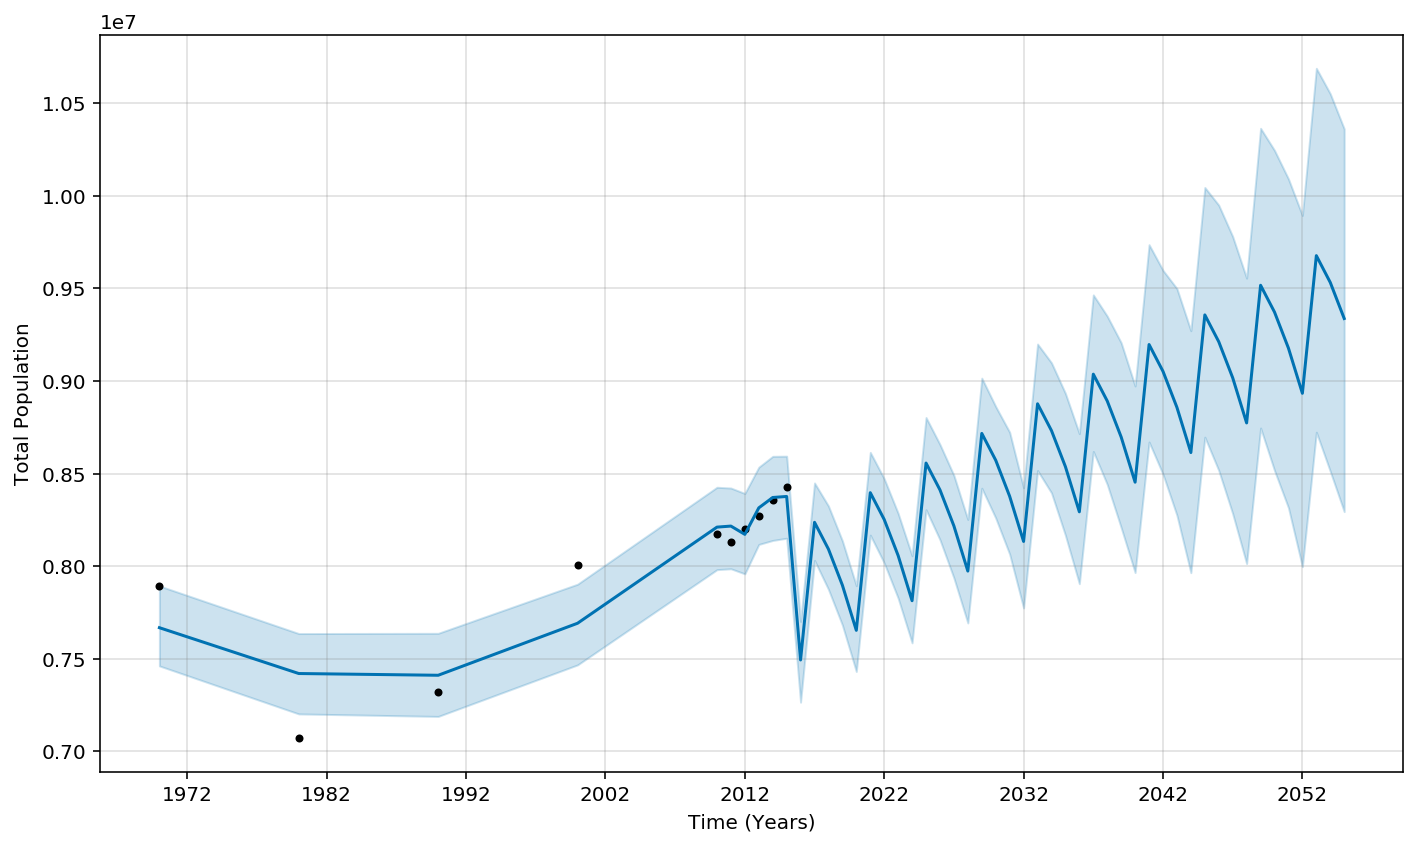

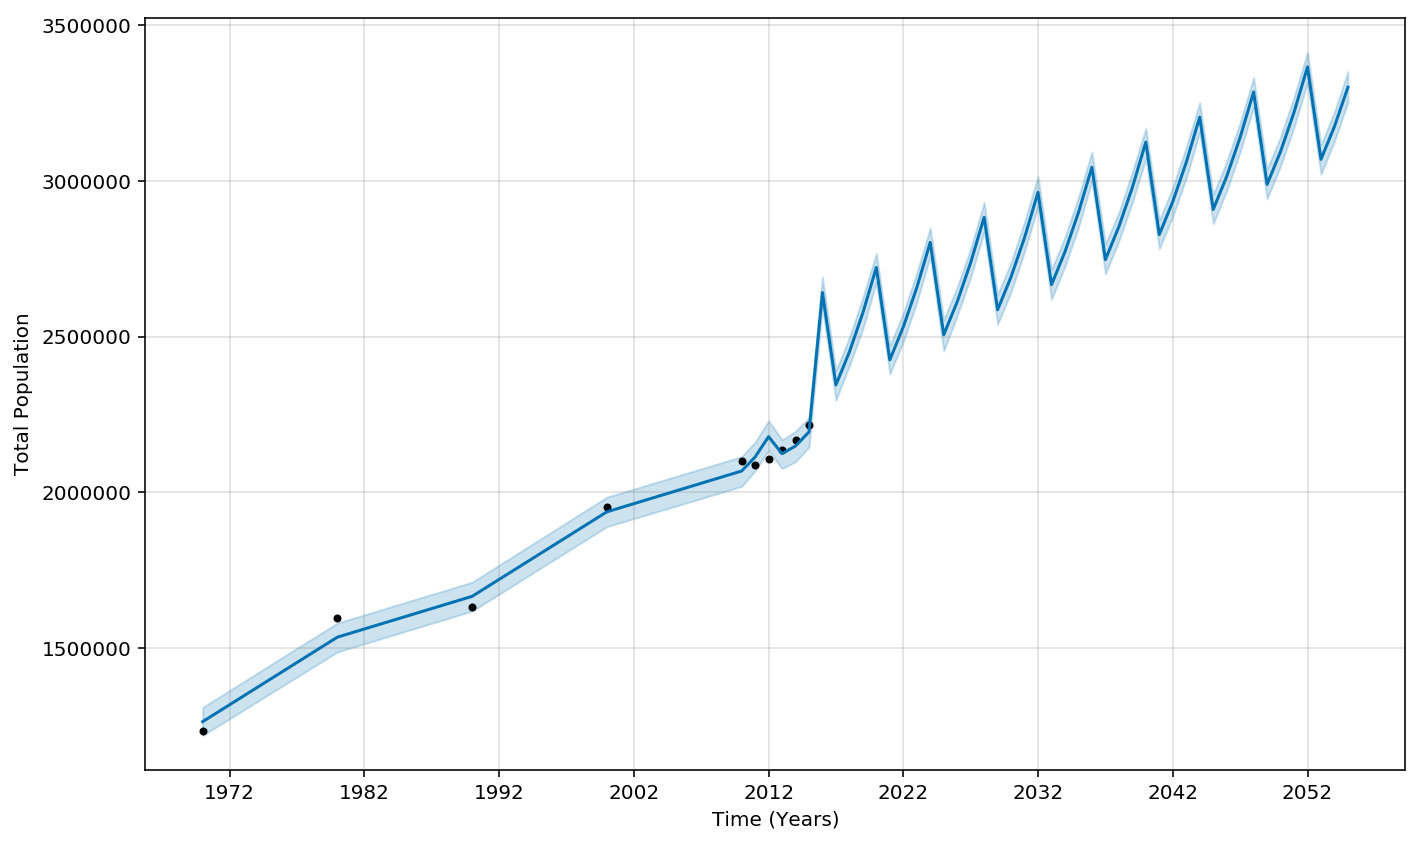

In [85]:
"""forecast 2016 and 2017 populations using model for each sample Place
"""
# set out route for forecast tables
out = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# set out for plots
plots = []
# record cross vals
xvals=[]

# make DataFrame of column values as datetime (first converting to Series)
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=train_df.columns)))

# go though each place in train_df
for i in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[i]
    # add datetime values to forge place specific DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15,
                                      daily_seasonality=False,
                                      weekly_seasonality=False,
                                      yearly_seasonality=True,
                                      n_changepoints=3)
    
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    
    # fit place on prophet model 
    place_prophet.fit(df)
    df_cv = cross_validation(place_prophet, initial='14235 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv) 
    print(df_p)
    xvals.append(df_p)
    
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe(periods=40, 
                                                         freq='Y')
    
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # model plot the forecase
    m_plot = place_prophet.plot(forecast, 
                                ax=None, 
                                uncertainty=True, 
                                plot_cap=True, 
                                xlabel='Time (Years)', 
                                ylabel='Total Population')
    # add to plots
    plots.append(m_plot)
    
    
    # tag and bag (forecast table)
    out.append(forecast)
    # store 2016 and 2017 predictions
    train_preds.append([
        forecast.loc[forecast.ds == '2016-12-31'].yhat.values[0],
        forecast.loc[forecast.ds == '2017-12-31'].yhat.values[0]])

In [79]:
for i in xvals:
    print(i.mape)

0    0.123748
1    0.054228
Name: mape, dtype: float64
0    0.000208
1    0.032192
Name: mape, dtype: float64
0    0.001882
1    0.014488
Name: mape, dtype: float64
0    0.039996
1    0.081600
Name: mape, dtype: float64
0    0.003056
1    0.009110
Name: mape, dtype: float64
0    0.001455
1    0.016098
Name: mape, dtype: float64
0    0.040433
1    0.021147
Name: mape, dtype: float64


In [80]:
xvals

[   horizon           mse         rmse          mae      mape  coverage
 0 364 days  1.944603e+07  4409.765821  4409.765821  0.123748  0.000000
 1 365 days  5.888431e+06  2426.609009  2134.920073  0.054228  0.666667,
    horizon           mse         rmse          mae      mape  coverage
 0 364 days  2.130062e+02    14.594730    14.594730  0.000208  0.000000
 1 365 days  7.638541e+06  2763.791079  2329.266181  0.032192  0.333333,
    horizon           mse          rmse           mae      mape  coverage
 0 364 days  2.309934e+06   1519.846706   1519.846706  0.001882  0.000000
 1 365 days  1.580660e+08  12572.431029  12046.998076  0.014488  0.333333,
    horizon           mse          rmse           mae      mape  coverage
 0 364 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
 1 365 days  1.346284e+09  36691.745112  30348.856274  0.081600       0.0,
    horizon          mse       rmse        mae      mape  coverage
 0 364 days   427.848866  20.684508  20.684508  0.003

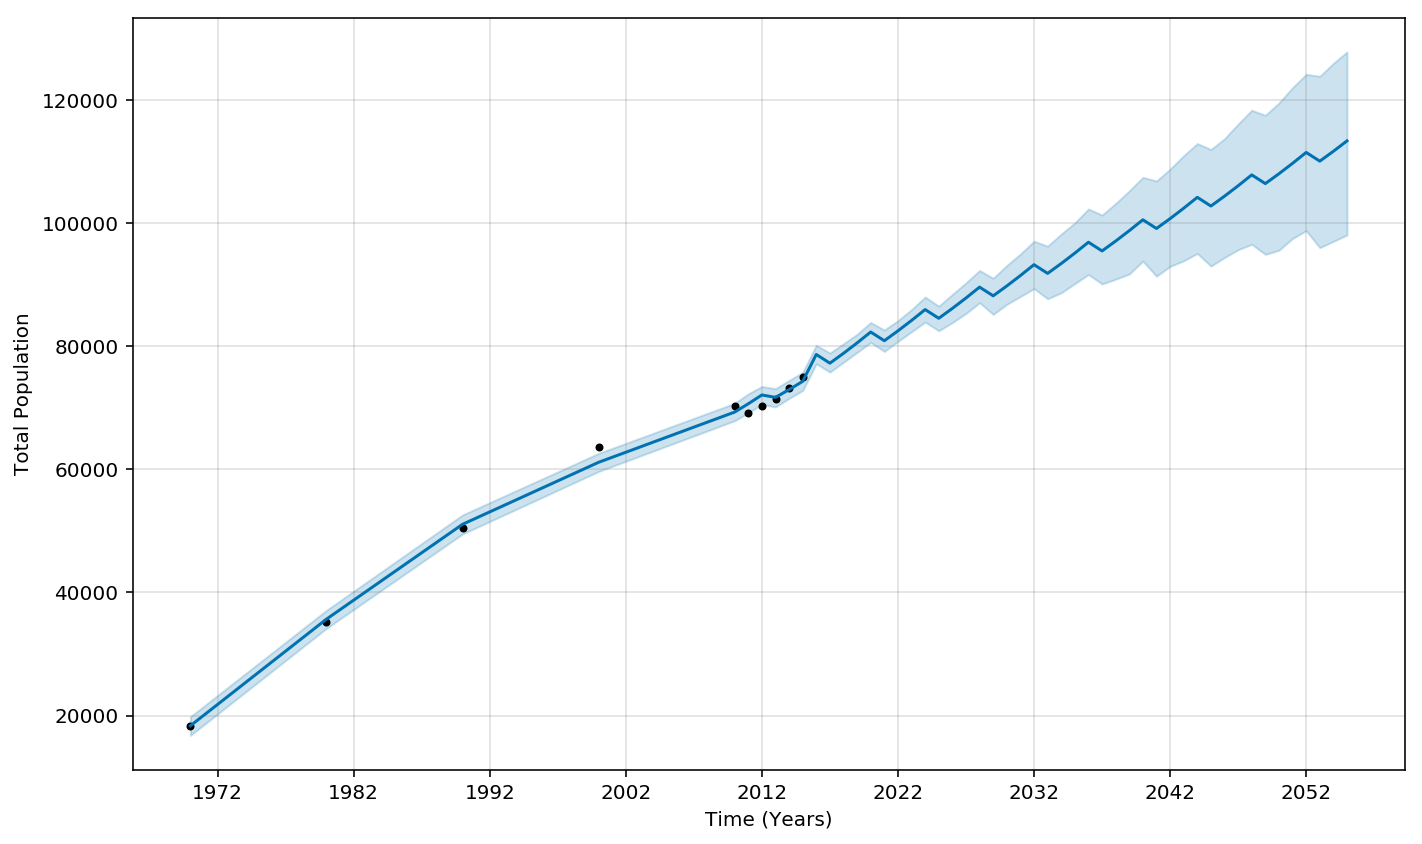

In [75]:
plots[1]

In [76]:
train_preds[2] # act16: 850,282    act17: 864,263

[811540.3453869702, 793029.8868455768]

In [12]:
# id city
bvil = train_df.iloc[0]
# rename Place df's columns to agree with prophet formatting
df.columns = ['drop','y','ds']
# adjust df ; forget index column (drop)
df = df[['ds','y']]
# make Prophet model 
m=fbprophet.Prophet(changepoint_prior_scale=0.15,
                                      daily_seasonality=False,
                                      weekly_seasonality=False,
                                      yearly_seasonality=True,
                                      n_changepoints=3)
# fit city to model
m.fit(bvil)
# model future df
future = m.make_future_dataframe(periods=40,
                                freq='Y')
# model predict to fill future df
forecast = m.predict(future)
# model plot the forecase
m.plot(forecast)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

In [8]:
out[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,-19156.300615,4534.484458,7061.626365,-19156.300615,-19156.300615,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,0.0,0.0,0.0,5830.412947
1,1980-01-01,-16348.533217,6304.404105,8689.470859,-16348.533217,-16348.533217,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,0.0,0.0,0.0,7469.139232
2,1990-01-01,-13539.996989,10290.588264,12619.025808,-13539.996989,-13539.996989,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,0.0,0.0,0.0,11446.716574
3,2000-01-01,-2193.747481,20411.595077,22789.889439,-2193.747481,-2193.747481,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,0.0,0.0,0.0,21623.924969
4,2010-01-01,9155.608887,32932.862622,35386.282569,9155.608887,9155.608887,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,0.0,0.0,0.0,34142.322450
5,2011-01-01,10289.612466,33770.113578,36079.584100,10289.612466,10289.612466,24610.535863,24610.535863,24610.535863,24610.535863,24610.535863,24610.535863,0.0,0.0,0.0,34900.148329
6,2012-01-01,11423.616045,34047.698429,36487.942301,11423.616045,11423.616045,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,23817.672449,0.0,0.0,0.0,35241.288494
7,2013-01-01,12560.726483,36264.710183,38713.833114,12560.726483,12560.726483,24945.717847,24945.717847,24945.717847,24945.717847,24945.717847,24945.717847,0.0,0.0,0.0,37506.444330
8,2014-01-01,13694.730062,37463.775758,39791.829329,13694.730062,13694.730062,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,24986.713563,0.0,0.0,0.0,38681.443625
9,2015-01-01,14828.733641,38328.951991,40680.668854,14828.733641,14828.733641,24610.535863,24610.535863,24610.535863,24610.535863,24610.535863,24610.535863,0.0,0.0,0.0,39439.269504


In [93]:
'''forecast 2016, 2017 & 2018 populations using model for each sample Place'''
# set out route for forecast tables
out = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# make DataFrame of column values as datetime
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=train_df.columns)))
# go though each place in train_df
for i in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[i]
    # add datetime values to DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.1)
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    # fit place on prophet model 
    place_prophet.fit(df)
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe( periods=4, freq='Y' )
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # tag and bag (forecast table)
    out.append(forecast)
    # store 2016 and 2017 predictions
    train_preds.append([
        forecast.loc[forecast.ds == '2016-12-31'].yhat.values[0],
        forecast.loc[forecast.ds == '2017-12-31'].yhat.values[0],
        forecast.loc[forecast.ds == '2018-12-31'].yhat.values[0]])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.


In [94]:
'''make Baseline predictions of 2016 and 2017 population on sample Places'''
# set out route
baseline_preds = []
# go though each place in train_df
for j in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[j]
    # identify 2011 population
    p11 = int(df['2011'])
    # identify 2012 population
    p12 = int(df['2012'])
    # identify 2013 population
    p13 = int(df['2013'])
    # identify 2014 population
    p14 = int(df['2014'])
    # identify 2015 population
    p15 = int(df['2015'])
    # calculate average change over time for 2016
    avg_16_change = np.mean(((p15-p14)+(p14-p13)))
    # make 2016 prediction 
    p_16 = p15 + avg_16_change
    # calculate average change over time for 2017
    avg_17_change = np.mean(((p15-p14)+(p_16-p15)))
    # make 2017 prediction 
    p_17 = p_16 + avg_16_change
    # pair prediction, tag & bag
    baseline_preds.append([p_16,p_17])

'''pull actual measurements for 2016 and 2017 population for each sample Place'''
# actual populations for 2016
test_16 = [actual_population for actual_population in test_16_df.HC01_EST_VC01]
# actual populations for 2017
test_17 = [actual_population for actual_population in test_17_df.HC01_EST_VC01]

In [95]:
'''2016'''
train_preds_16 = [float(pred[0]) for pred in train_preds]
test_16_ = [float(act) for act in test_16]
MODEL_rmse_exrate16 = sqrt(mean_squared_error(y_true=test_16_,y_pred=train_preds_16))
base_preds_16 = [float(pred[0]) for pred in baseline_preds]
test_16_ = [float(act) for act in test_16]
BASE_rmse_exrate16 = sqrt(mean_squared_error(y_true=test_16_,y_pred=base_preds_16))
print(MODEL_rmse_exrate16,BASE_rmse_exrate16 ) 

'''2017'''
train_preds_17 = [float(pred[1]) for pred in train_preds]
test_17_ = [float(act) for act in test_17]
MODEL_rmse_exrate17 = sqrt(mean_squared_error(y_true=test_17_,y_pred=train_preds_17))
base_preds_17 = [float(pred[1]) for pred in baseline_preds]
test_17_ = [float(act) for act in test_17]
BASE_rmse_exrate17 = sqrt(mean_squared_error(y_true=test_17_,y_pred=base_preds_17))
print(MODEL_rmse_exrate17,BASE_rmse_exrate17)  

2495.5513721943134 1484.0
5791.195187820558 2710.0


In [96]:
train_preds_16,train_preds_17

([74550.44862780569], [73549.80481217944])

In [97]:
base_preds_16,base_preds_17

([78530.0], [82051.0])

In [98]:
test_16,test_17

(['77046'], [79341])

In [90]:
# forecast